In [1]:
!wget https://raw.githubusercontent.com/summitgao/CAMixer/main/preclassify.py

--2021-04-09 06:22:05--  https://raw.githubusercontent.com/summitgao/DRCNN/master/preclassify.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5660 (5.5K) [text/plain]
Saving to: ‘preclassify.py’

preclassify.py      100%[===================>]   5.53K  --.-KB/s    in 0s      

2021-04-09 06:22:05 (68.6 MB/s) - ‘preclassify.py’ saved [5660/5660]



In [2]:
import numpy as np
import skimage
from skimage import io, measure
import random
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from preclassify import del2, srad, dicomp, FCM, hcluster
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
from collections import  Counter



im1_path  = 'ottawa_1.bmp'
im2_path  = 'ottawa_2.bmp'
imgt_path = 'ottawa_gt.bmp'

# important parameter
patch_size = 7

In [3]:
def image_normalize(data):
    import math
    _mean = np.mean(data)
    _std = np.std(data)
    npixel = np.size(data) * 1.0
    min_stddev = 1.0 / math.sqrt(npixel)
    return (data - _mean) / max(_std, min_stddev)

def image_padding(data,r):
    if len(data.shape)==3:
        data_new=np.lib.pad(data,((r,r),(r,r),(0,0)),'constant',constant_values=0)
        return data_new
    if len(data.shape)==2:
        data_new=np.lib.pad(data,r,'constant',constant_values=0)
        return data_new
#生成自然数数组并打乱
def arr(length):
  arr=np.arange(length-1)
  #print(arr)
  random.shuffle(arr)
  #print(arr)
  return arr


# 在每个像素周围提取 patch ，然后创建成符合 pytorch 处理的格式
def createTrainingCubes(X, y, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    # 把类别 uncertainty 的像素忽略
    ele_num1 = np.sum(y==1)
    ele_num2 = np.sum(y==2)
    patchesData_1 = np.zeros( (ele_num1, patch_size, patch_size, X.shape[2]) )
    patchesLabels_1 = np.zeros(ele_num1)

    patchesData_2 = np.zeros((ele_num2, patch_size, patch_size, X.shape[2]))
    patchesLabels_2 = np.zeros(ele_num2)

    patchIndex_1 = 0
    patchIndex_2 = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            # remove uncertainty pixels
            if y[r-margin, c-margin] == 1 :
                patch_1 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_1[patchIndex_1, :, :, :] = patch_1
                patchesLabels_1[patchIndex_1] = y[r-margin, c-margin]
                patchIndex_1 = patchIndex_1 + 1
            elif y[r-margin, c-margin] == 2 :
                patch_2 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_2[patchIndex_2, :, :, :] = patch_2
                patchesLabels_2[patchIndex_2] = y[r-margin, c-margin]
                patchIndex_2 = patchIndex_2 + 1
    patchesLabels_1 = patchesLabels_1-1
    patchesLabels_2 = patchesLabels_2-1
    
    #调用arr函数打乱数组
    arr_1=arr(len(patchesData_1))
    arr_2=arr(len(patchesData_2))

    train_len=10000  #设置训练集样本数
    pdata=np.zeros((train_len, patch_size, patch_size, X.shape[2]))
    plabels = np.zeros(train_len)
    
    for i in range(7000):
      pdata[i,:,:,:]=patchesData_1[arr_1[i],:,:,:]
      plabels[i]=patchesLabels_1[arr_1[i]]
    for j in range(7000,train_len):
      pdata[j,:,:,:]=patchesData_2[arr_2[j-7000],:,:,:]
      plabels[j]=patchesLabels_2[arr_2[j-7000]]

    return pdata, plabels


def createTestingCubes(X, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    patchesData = np.zeros( (X.shape[0]*X.shape[1], patch_size, patch_size, X.shape[2]) )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchIndex = patchIndex + 1
    return patchesData   


#  Inputs:  gtImg  = ground truth image
#           tstImg = change map
#  Outputs: FA  = False alarms
#           MA  = Missed alarms
#           OE  = Overall error
#           PCC = Overall accuracy
def evaluate(gtImg, tstImg):
    gtImg[np.where(gtImg>128)] = 255
    gtImg[np.where(gtImg<128)] = 0
    tstImg[np.where(tstImg>128)] = 255
    tstImg[np.where(tstImg<128)] = 0
    [ylen, xlen] = gtImg.shape
    FA = 0
    MA = 0
    label_0 = np.sum(gtImg==0)
    label_1 = np.sum(gtImg==255)
    print(label_0)
    print(label_1)

    for j in range(0,ylen):
        for i in range(0,xlen):
            if gtImg[j,i]==0 and tstImg[j,i]!=0 :
                FA = FA+1
            if gtImg[j,i]!=0 and tstImg[j,i]==0 :
                MA = MA+1
  
    OE = FA+MA
    PCC = 1-OE/(ylen*xlen)
    PRE=((label_1+FA-MA)*label_1+(label_0+MA-FA)*label_0)/((ylen*xlen)*(ylen*xlen))
    KC=(PCC-PRE)/(1-PRE)
    print(' Change detection results ==>')
    print(' ... ... FP:  ', FA)
    print(' ... ... FN:  ', MA)
    print(' ... ... OE:  ', OE)
    print(' ... ... PCC: ', format(PCC*100, '.2f'))
    print(' ... ... KC: ', format(KC*100, '.2f'))


def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    num = res.max()
    for i in range(1, num+1):
        idy, idx = np.where(res==i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

In [4]:
# read image, and then tranform to float32
im1 = io.imread(im1_path)[:,:,0].astype(np.float32)
im2 = io.imread(im2_path)[:,:,0].astype(np.float32)

im_gt = io.imread(imgt_path)[:,:,0].astype(np.float32)

im_di = dicomp(im1, im2)
ylen, xlen = im_di.shape
pix_vec = im_di.reshape([ylen*xlen, 1])


# hiearchical FCM clustering
# in the preclassification map, 
# pixels with high probability to be unchanged are labeled as 1
# pixels with high probability to be changed are labeled as 2
# pixels with uncertainty are labeled as 1.5
preclassify_lab = hcluster(pix_vec, im_di)
print('... ... hiearchical clustering finished !!!')


mdata = np.zeros([im1.shape[0], im1.shape[1], 3], dtype=np.float32)
mdata[:,:,0] = im1
mdata[:,:,1] = im2
mdata[:,:,2] = im_di
mlabel = preclassify_lab

x_train, y_train = createTrainingCubes(mdata, mlabel, patch_size)
x_train = x_train.transpose(0, 3, 1, 2)
print('... x train shape: ', x_train.shape)
print('... y train shape: ', y_train.shape)


x_test = createTestingCubes(mdata, patch_size)
x_test = x_test.transpose(0, 3, 1, 2)
print('... x test shape: ', x_test.shape)

... ... 1st round clustering ... ...
... ... 2nd round clustering ... ...
... ... hiearchical clustering finished !!!
... x train shape:  (10000, 3, 7, 7)
... y train shape:  (10000,)
... x test shape:  (101500, 3, 7, 7)


In [5]:

""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_data = torch.FloatTensor(x_train)
        self.y_data = torch.LongTensor(y_train)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        
        #x=torch.FloatTensor(data_rotate(self.x_data[index].cpu().numpy()))
        #y=torch.FloatTensor(gasuss_noise(self.y_data[index]))
        #x=torch.FloatTensor(datarotate(self.x_data[index]))
        #return x,self.y_data[index]
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)

In [19]:
class MRC(nn.Module):
    def __init__(self, inchannel):
        super(MRC, self).__init__() 
        self.conv1 = nn.Conv2d(inchannel, 15, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(15)

        self.conv2_1 = nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_1 = nn.BatchNorm2d(5)

        self.conv2_2 = nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_2 = nn.BatchNorm2d(5)

        self.conv2_3 = nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_3 = nn.BatchNorm2d(5)

    def forward(self, x):
        ori_out = F.relu(self.bn1(self.conv1(x)))

        shape=(x.shape[0], 5, 7, 7)

        all_zero3_3=torch.zeros(size=shape).cuda()
        all_zero1_3=torch.zeros(size=(x.shape[0], 5, 3, 7)).cuda()
        all_zero3_1=torch.zeros(size=(x.shape[0], 5, 7, 3)).cuda()

        all_zero3_3[:,:,:,:]=ori_out[:,0:5,:,:]
        all_zero1_3[:,:,:,:]=ori_out[:,5:10,2:5,:]
        all_zero3_1[:,:,:,:]=ori_out[:,10:15,:,2:5]

        square=F.relu(self.bn2_1(self.conv2_1(all_zero3_3)))
        horizontal=F.relu(self.bn2_2(self.conv2_2(all_zero1_3)))
        vertical=F.relu(self.bn2_3(self.conv2_3(all_zero3_1)))
        horizontal_final=torch.zeros(size=(x.shape[0], 5, 7, 7)).cuda()
        vertical_final=torch.zeros(size=(x.shape[0], 5, 7, 7)).cuda()
        horizontal_final[:,:,2:5,:]=horizontal[:,:,:,:]
        vertical_final[:,:,:,2:5]=vertical[:,:,:,:]

        glo = square + horizontal_final + vertical_final
        #glo= F.relu(self.bn3(self.conv3(glo)))
        
        return glo

def DCT(x):
      out=F.interpolate(x, size=(8,8), mode='bilinear', align_corners=True)
      #print(out.shape)
      #dct_out_1 =torch.Tensor([cv2.dct(x[i,0,:,:].detach().cpu().numpy()) \
      #                          for i in range(x.shape[0])])
      dct_out_1 =torch.Tensor([cv2.dct(np.float32(out[i,0,:,:].detach().cpu().numpy())) \
                                for i in range(x.shape[0])])
      dct_out_2 =torch.Tensor([cv2.dct(np.float32(out[i,1,:,:].detach().cpu().numpy())) \
                                for i in range(x.shape[0])])
      dct_out_3 =torch.Tensor([cv2.dct(np.float32(out[i,2,:,:].detach().cpu().numpy())) \
                                for i in range(x.shape[0])])
      dct_out=torch.zeros(size=(x.shape[0],3, 8, 8))
      dct_out[:,0,:,:]=dct_out_1 
      dct_out[:,1,:,:]=dct_out_2
      dct_out[:,2,:,:]=dct_out_3
      dct_out=dct_out.cuda()#放回cuda
      out=dct_out.view(x.shape[0], 3, 64)
      #out=torch.cat((out,out),2)
      out=F.glu(out,dim=-1)
      dct_out=out.view(x.shape[0], 1, 96)
      return dct_out


In [20]:

class DDNet(nn.Module):
    def __init__(self):
        super(DDNet, self).__init__() 
        self.mrc1=MRC(3)
        self.mrc2=MRC(5)
        self.mrc3=MRC(5)
        self.mrc4=MRC(5)


        self.linear1=nn.Linear(341, 10) 
        self.linear2=nn.Linear(10, 2)

    def forward(self, x):

        m_1=self.mrc1(x)
        m_2=self.mrc2(m_1)
        m_3=self.mrc3(m_2)
        m_4=self.mrc4(m_3)
        #glo= F.relu(self.bn(self.conv(m_4)))
        glo=m_4.view(x.shape[0], 1, 245)

        dct_out=DCT(x)
        
        out=torch.cat((glo,dct_out),2)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out_1 = self.linear1(out)
        out = self.linear2(out_1)

        return out       

In [23]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
istrain = True
# 网络放到GPU上
net =DDNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()

# 开始训练
total_loss = 0
for epoch in range(50):
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]  [loss avg: %.4f]  [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
print('Finished Training')



[Epoch: 1]  [loss avg: 28.7589]  [current loss: 0.0230]
[Epoch: 2]  [loss avg: 15.0045]  [current loss: 0.0235]
[Epoch: 3]  [loss avg: 10.2958]  [current loss: 0.0013]
[Epoch: 4]  [loss avg: 7.8826]  [current loss: 0.0025]
[Epoch: 5]  [loss avg: 6.4163]  [current loss: 0.0820]
[Epoch: 6]  [loss avg: 5.4676]  [current loss: 0.0001]
[Epoch: 7]  [loss avg: 4.7589]  [current loss: 0.0206]
[Epoch: 8]  [loss avg: 4.2053]  [current loss: 0.0004]
[Epoch: 9]  [loss avg: 3.7589]  [current loss: 0.0016]
[Epoch: 10]  [loss avg: 3.3987]  [current loss: 0.0003]
[Epoch: 11]  [loss avg: 3.1150]  [current loss: 0.1460]
[Epoch: 12]  [loss avg: 2.9408]  [current loss: 0.0006]
[Epoch: 13]  [loss avg: 2.7270]  [current loss: 0.0003]
[Epoch: 14]  [loss avg: 2.8225]  [current loss: 3.9782]
[Epoch: 15]  [loss avg: 2.8149]  [current loss: 0.0188]
[Epoch: 16]  [loss avg: 2.6657]  [current loss: 0.0365]
[Epoch: 17]  [loss avg: 2.5224]  [current loss: 0.0005]
[Epoch: 18]  [loss avg: 2.3929]  [current loss: 0.0000

... ... row 50  handling ... ...
... ... row 100  handling ... ...
... ... row 150  handling ... ...
... ... row 200  handling ... ...
... ... row 250  handling ... ...
... ... row 300  handling ... ...
... ... row 350  handling ... ...
85451
16049
 Change detection results ==>
 ... ... FP:   637
 ... ... FN:   1051
 ... ... OE:   1688
 ... ... PCC:  98.34
 ... ... KC:  93.69


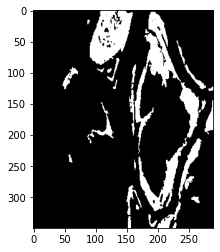

In [24]:
# 逐像素预测类别
istrain=False
net.eval()
outputs = np.zeros((ylen, xlen))
glo_fin=torch.Tensor([]).cuda()
dct_fin=torch.Tensor([]).cuda()
for i in range(ylen):
    for j in range(xlen):
        if preclassify_lab[i, j] != 1.5 :
            outputs[i, j] = preclassify_lab[i, j]
        else:
            img_patch = x_test[i*xlen+j, :, :, :]
            img_patch = img_patch.reshape(1, img_patch.shape[0], img_patch.shape[1], img_patch.shape[2])
            img_patch = torch.FloatTensor(img_patch).to(device)
            prediction = net(img_patch)

            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i, j] = prediction+1
    if (i+1) % 50 == 0:
        print('... ... row', i+1, ' handling ... ...')

outputs = outputs-1

plt.imshow(outputs, 'gray')


res = outputs*255
res = postprocess(res)
evaluate(im_gt, res)
plt.imshow(res, 'gray') 